# Clustering Seed Types

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for
the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.

The data set can be used for the tasks of classification and cluster analysis.

### Start Spark Session

In [2]:
from pyspark.sql import SparkSession
%matplotlib inline

In [4]:
spark = SparkSession.builder.appName('Clustering').getOrCreate()

### Read Data

In [5]:
df = spark.read.csv('seeds_dataset.csv', header=True, inferSchema=True)

### Data Analysis

In [6]:
df.count()

210

In [7]:
df.printSchema()

root
 |-- area: double (nullable = true)
 |-- perimeter: double (nullable = true)
 |-- compactness: double (nullable = true)
 |-- length_of_kernel: double (nullable = true)
 |-- width_of_kernel: double (nullable = true)
 |-- asymmetry_coefficient: double (nullable = true)
 |-- length_of_groove: double (nullable = true)



In [8]:
df.show(10)

+-----+---------+-----------+------------------+------------------+---------------------+------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|  length_of_groove|
+-----+---------+-----------+------------------+------------------+---------------------+------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|              5.22|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|             4.956|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|             4.825|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|             4.805|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|             5.175|
|14.38|    14.21|     0.8951|             5.386|             3.312|   2.4619999999999997|             4.956|
|14.69|    14.49|  

In [9]:
df.describe().show()

+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|summary|              area|         perimeter|         compactness|   length_of_kernel|   width_of_kernel|asymmetry_coefficient|   length_of_groove|
+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|  count|               210|               210|                 210|                210|               210|                  210|                210|
|   mean|14.847523809523816|14.559285714285718|  0.8709985714285714|  5.628533333333335| 3.258604761904762|   3.7001999999999997|  5.408071428571429|
| stddev|2.9096994306873647|1.3059587265640225|0.023629416583846364|0.44306347772644983|0.3777144449065867|   1.5035589702547392|0.49148049910240543|
|    min|             10.59|             12.41|              0.8081|              4.899|            

### Transform Data

In [10]:
from pyspark.ml.feature import VectorAssembler

In [11]:
assembler = VectorAssembler(inputCols=df.columns, outputCol='features')

In [12]:
final_data = assembler.transform(df)

### Scale Data for Clustering

In [13]:
from pyspark.ml.feature import StandardScaler

In [14]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')#, withMean=True, withStd=False)
scaler_model = scaler.fit(final_data)
final_data_scaled = scaler_model.transform(final_data)

In [15]:
final_data_scaled.select('scaledFeatures').show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------------------------------+
|[5.244527953320284,11.363299389287777,36.860833906302894,13.007165541092315,8.76852883087142,1.4771618831975104,10.62097073949694] |
|[5.113930271651758,11.156554723849252,37.28826722714521,12.53544983779745,8.824126386864265,0.6770602418257837,10.08381819634997]  |
|[4.911160186955888,10.789008651958541,38.29971835270278,11.94185543604363,8.834716397529569,1.7950742560783792,9.817276593500525]  |
|[4.756505037611581,10.674150504492696,37.89767711032634,12.01633686287966,8.945911509515255,1.5024352517528932,9.776583219019694]  |
|[5.546964689815818,11.478157536753622,38.23200614346043,12.77

### Try Different K's in Kmeans Clustering

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [17]:
import pandas as pd
model_dict = {}
evaluator = ClusteringEvaluator()
plot_df = pd.DataFrame(data={'k':[],'distance':[]})

for i in range(2, 20):
    kmeans = KMeans(featuresCol='scaledFeatures', k=i).setSeed(1)
    model_dict[i] = kmeans.fit(final_data_scaled)
    predictions = model_dict[i].transform(final_data_scaled)
    silhouette = evaluator.evaluate(predictions)
    plot_df = plot_df.append(pd.DataFrame(data={'k':[i],'distance':[silhouette]}))
    
plot_df.set_index('k', inplace=True)

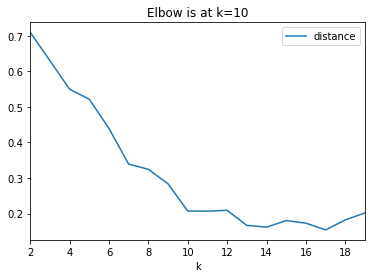

In [18]:
plot_df.plot(title='Elbow is at k=10')

### Results

In [19]:
centers = model_dict[10].clusterCenters()
for i, center in enumerate(centers):
    print('Center: ', i, ':', center)

Center:  0 : [ 5.65235931 11.7623251  37.05056916 13.28427657  9.13756129  2.99740673
 11.67911151]
Center:  1 : [ 6.69347486 12.77804548 37.17163295 14.42791004  9.97356614  2.74492726
 12.69372846]
Center:  2 : [ 4.15313516 10.23960385 35.91180497 11.87795376  7.59916     1.91183888
 10.25854537]
Center:  3 : [ 4.63764969 10.57652108 37.57851279 11.93884609  8.42115442  1.64767398
  9.92036648]
Center:  4 : [ 5.04906103 11.16421193 36.74921456 12.79839184  8.54271892  1.78559674
 10.76950156]
Center:  5 : [ 6.37828385 12.36724468 37.82385199 13.82060972  9.91224998  1.85783892
 12.19248858]
Center:  6 : [ 5.39689192 11.36380987 37.90360193 12.69208654  9.19918926  1.34636112
 10.63656987]
Center:  7 : [ 4.4960734  10.47165984 37.16553885 11.95539751  8.25197164  4.50131996
 10.35782025]
Center:  8 : [ 3.91779298 10.0698435  35.04208397 11.85635979  7.20417246  3.44406844
 10.48676399]
Center:  9 : [ 4.14794021 10.14835543 36.5098903  11.72852592  7.74737725  3.12099005
 10.3098925 ]


In [20]:
spark.stop()